##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning with TensorFlow Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

This tutorial demonstrates how to:

1. Use models from TensorFlow Hub with `tf.keras`.
1. Use an image classification model from TensorFlow Hub.
1. Do simple transfer learning to fine-tune a model for your own image classes.

## Setup

In [2]:
%pip install numpy
%pip install tensorflow
%pip install matplotlib 
%pip install pillow
%pip install setuptools
%pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.16.0-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
Using cached tf_keras-2.16.0-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import time
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub


import datetime


%load_ext tensorboard

### Download the classifier

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Any <a href="https://tfhub.dev/s?q=tf2&module-type=image-classification/" class="external">compatible image classifier model</a> from TensorFlow Hub will work here, including the examples provided in the drop-down below.

In [2]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [3]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

## Simple transfer learning

But what if you want to create a custom classifier using your own dataset that has classes that aren't included in the original ImageNet dataset (that the pre-trained model was trained on)?

To do that, you can:

1. Select a pre-trained model from TensorFlow Hub; and
2. Retrain the top (last) layer to recognize the classes from your custom dataset.

### Dataset

In this example, you will use the TensorFlow flowers dataset:

In [35]:
import pathlib

data_root_train = pathlib.Path("./datasets/v1/train").with_suffix('')
data_root_val = pathlib.Path("./datasets/v1/validate").with_suffix('')

print(data_root_val, data_root_train)

datasets/v1/validate datasets/v1/train


In [36]:
data_dir = data_root_train

# List to store pixel values of all images
pixel_values = []

# Iterate through each image in the directory
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_path):
        # Iterate through each image in the class directory
        for filename in os.listdir(class_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Assuming images are in jpg or png format
                # Open the image using PIL
                img = Image.open(os.path.join(class_path, filename))
                # Convert the image to numpy array
                img_array = np.array(img)
                # Flatten the image and append to pixel_values list
                pixel_values.append(img_array.reshape(-1, 3))

pixel_values = np.concatenate(pixel_values, axis=0)

# Calculate mean and standard deviation using NumPy
mean = np.mean(pixel_values, axis=0)
std_dev = np.std(pixel_values, axis=0)

print("Mean:", mean)
print("Standard Deviation:", std_dev)

Mean: [108.21201705 105.07084894  94.04962223]
Standard Deviation: [65.1505389  62.59698394 64.23141208]


First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [112]:
batch_size = 128
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root_train),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root_val),
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2322 files belonging to 4 classes.
Found 141 files belonging to 4 classes.


In [113]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)

(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(128, 224, 224, 3)
(128,)
(18, 224, 224, 3)
(18,)


2024-04-06 03:07:43.554141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The Dataset has these many classes:

In [114]:
class_names = np.array(train_ds.class_names)
for x in class_names:
    print(x)

LAN
POWER PORT
POWER SWITCH
WAN ETHERNET


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

Note: You could also include the `tf.keras.layers.Rescaling` layer inside the model. Refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide for a discussion of the tradeoffs.

In [115]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

Third, finish the input pipeline by using buffered prefetching with `Dataset.prefetch`, so you can yield the data from disk without I/O blocking issues.

These are some of the most important `tf.data` methods you should use when loading data. Interested readers can learn more about them, as well as how to cache data to disk and other techniques, in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance#prefetching) guide.

In [116]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [117]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(tf.math.reduce_std(
    image_batch, axis=3, keepdims=False, name=None
))


(128, 224, 224, 3)
(128,)
tf.Tensor(
[[[8.4715560e-03 8.4715560e-03 8.4715560e-03 ... 3.2019471e-03
   3.2019471e-03 3.2019471e-03]
  [8.4715560e-03 8.4715560e-03 8.4715560e-03 ... 3.2019471e-03
   3.2019471e-03 3.2019471e-03]
  [8.4715560e-03 8.4715560e-03 8.4715560e-03 ... 3.2019471e-03
   3.2019471e-03 3.2019471e-03]
  ...
  [1.7634952e-02 1.7634952e-02 1.7634952e-02 ... 1.9476684e-02
   1.9476684e-02 1.9476684e-02]
  [1.7634952e-02 1.7634952e-02 1.7634952e-02 ... 1.9476684e-02
   1.9476684e-02 1.9476684e-02]
  [1.7634952e-02 1.7634952e-02 1.7634952e-02 ... 1.9476684e-02
   1.9476684e-02 1.9476684e-02]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]

2024-04-06 03:07:47.908977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [118]:
pixel_means = []
pixel_stds = []
total_samples = 0
for image_batch, labels_batch in train_ds:
    pixel_means.append(np.mean(image_batch, axis=(0, 1, 2)))
    pixel_stds.append(np.std(image_batch, axis=(0, 1, 2)))
    total_samples += image_batch.shape[0]
    
mean = np.mean(pixel_means, axis=0)
std = np.mean(pixel_stds, axis=0)

print("Overall Mean:", mean)
print("Overall Std:", std)

Overall Mean: [0.24796219 0.25571847 0.24300198]
Overall Std: [0.26268384 0.25356188 0.24591589]


2024-04-06 03:07:50.955313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily perform transfer learning.

Select a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV2</a> pre-trained model <a href="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" class="external">from TensorFlow Hub</a>. Any <a href="https://tfhub.dev/s?module-type=image-feature-vector&q=tf2" class="external">compatible image feature vector model</a> from TensorFlow Hub will work here, including the examples from the drop-down menu.

In [119]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

Create the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [120]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 in this example):

In [121]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(18, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [122]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [123]:
predictions = model(image_batch)

In [124]:
predictions.shape

TensorShape([18, 4])

### Train the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [125]:
model.compile(
  optimizer=tf.keras.optimizers.legacy.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [126]:
NUM_EPOCHS = 30

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/30
19/19 [==============================] - 17s 826ms/step - loss: 0.9380 - acc: 0.6684 - val_loss: 0.5690 - val_acc: 0.8227
Epoch 2/30
19/19 [==============================] - 13s 700ms/step - loss: 0.2589 - acc: 0.9285 - val_loss: 0.4444 - val_acc: 0.8511
Epoch 3/30
19/19 [==============================] - 12s 650ms/step - loss: 0.1695 - acc: 0.9500 - val_loss: 0.3350 - val_acc: 0.8794
Epoch 4/30
19/19 [==============================] - 12s 637ms/step - loss: 0.1314 - acc: 0.9634 - val_loss: 0.3056 - val_acc: 0.8865
Epoch 5/30
19/19 [==============================] - 12s 640ms/step - loss: 0.1104 - acc: 0.9716 - val_loss: 0.2791 - val_acc: 0.8794
Epoch 6/30
19/19 [==============================] - 12s 652ms/step - loss: 0.0960 - acc: 0.9789 - val_loss: 0.2602 - val_acc: 0.8794
Epoch 7/30
19/19 [==============================] - 13s 667ms/step - loss: 0.0850 - acc: 0.9819 - val_loss: 0.2476 - val_acc: 0.8936
Epoch 8/30
19/19 [==============================] - 12s 657ms/step - 

Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [105]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 5314), started 1:04:54 ago. (Use '!kill 5314' to kill it.)

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Check the predictions

Obtain the ordered list of class names from the model predictions:

In [106]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
print(predicted_id)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 0s 490ms/step
tf.Tensor([2 2 3 3 1 2 1 2 2 0 1 0 2 2 3 3 1 2], shape=(18,), dtype=int64)
['POWER SWITCH' 'POWER SWITCH' 'WAN ETHERNET' 'WAN ETHERNET' 'POWER PORT'
 'POWER SWITCH' 'POWER PORT' 'POWER SWITCH' 'POWER SWITCH' 'LAN'
 'POWER PORT' 'LAN' 'POWER SWITCH' 'POWER SWITCH' 'WAN ETHERNET'
 'WAN ETHERNET' 'POWER PORT' 'POWER SWITCH']


Plot the model predictions:

2024-04-06 02:54:22.373558: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 18 of dimension 0 out of bounds.
2024-04-06 02:54:22.373578: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 18 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 18 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

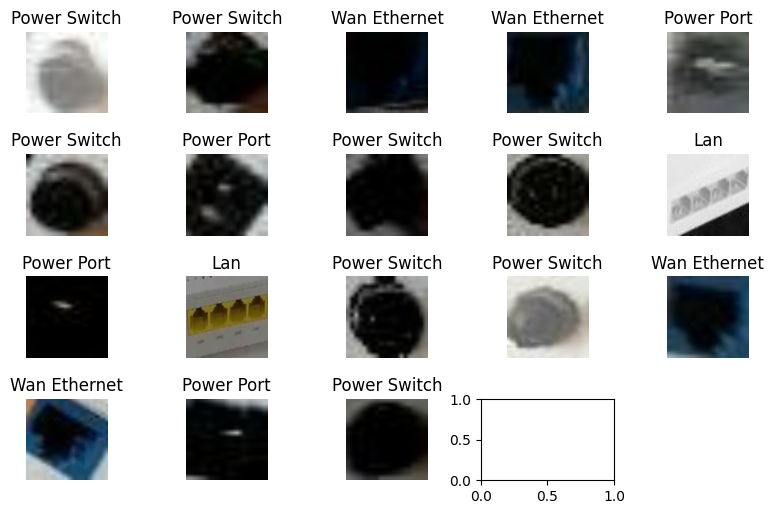

In [107]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export and reload your model

Now that you've trained the model, export it as a SavedModel for reusing it later.

In [108]:
t = time.time()

export_path = "./saved_models/{}".format(int(t))
model.save(export_path)

print(export_path)

INFO:tensorflow:Assets written to: ./saved_models/1712368467/assets


INFO:tensorflow:Assets written to: ./saved_models/1712368467/assets


./saved_models/1712368467


Confirm that you can reload the SavedModel and that the model is able to output the same results:

In [84]:
reloaded = tf.keras.models.load_model(export_path)

In [85]:

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 336ms/step


In [86]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [87]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['LAN' 'WAN ETHERNET']


2024-04-06 02:04:24.521536: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 2 of dimension 0 out of bounds.
2024-04-06 02:04:24.521560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 2 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 2 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

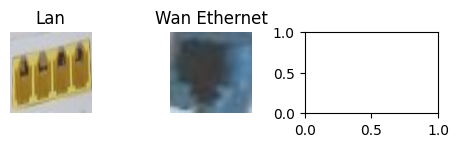

In [88]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## Next steps

You can use the SavedModel to load for inference or convert it to a [TensorFlow Lite](https://www.tensorflow.org/lite/models/convert/)  model (for on-device machine learning) or a [TensorFlow.js](https://www.tensorflow.org/js/tutorials#convert_pretrained_models_to_tensorflowjs) model (for machine learning in JavaScript).

Discover [more tutorials](https://www.tensorflow.org/hub/tutorials) to learn how to use pre-trained models from TensorFlow Hub on image, text, audio, and video tasks.